In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ising import Ising
from IPython import display
import matplotlib as mpl

# parameters for plots
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# critical temperature for ising2d
T_c = 2/np.log(1+np.sqrt(2))

## Equilibrium configuration
We plot the evolution of the system for 3 different temperature
- $T<T_c$
- $T=T_c$
- $T>T_c$

First we use matropolis algorithm and then metropolis in mean field approximation

Befor run the code we plot the magnetization over steps to be sure to use the right number of iterations and reach the equilibrium

In [5]:
# we run the metropolis algorithm in order to test it
test = Ising(50, 50, 0.5, 0, 1)
for _ in range(100000):
    test.metropolis(1)

KeyboardInterrupt: 

In [ ]:
# we visualize the magnetization in order to see if the system reach the equilibrium
plt.plot(test.mag);

KeyboardInterrupt: 

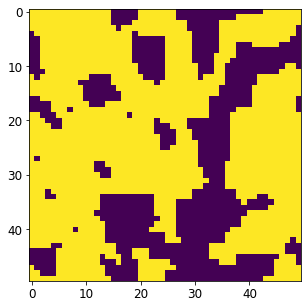

In [2]:
# we run again the metropolis algorithm for three different temperatures
#this time we save the image of the final configuration in order to visualize the final state of the system
temperatures = [0.5, T_c, 4]

for T in temperatures:
    # create initial random configuration
    ising = Ising(50, 50, T, 0, 1)

    # set up figure, plot first frame
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    # draw the initial configuration,
    # naming the plot "im".
    im = ax.imshow(ising.matrix)
    
    for t in range(10000):
        # update the system
        ising.metropolis(10)
        # replot every 1000 MC updates
        if t%100==0:
            # update the data of the plot (not the whole figure!)
            im.set_data(ising.matrix)
            # rerender
            display.display(plt.gcf())
            display.clear_output(wait=True)


    # save the final configuration
    fig.savefig(f'./fig/final_state_{T}.pdf', dpi=720)

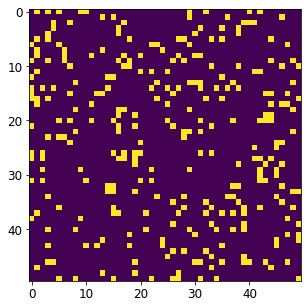

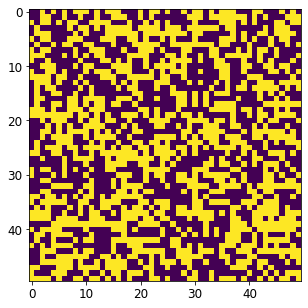

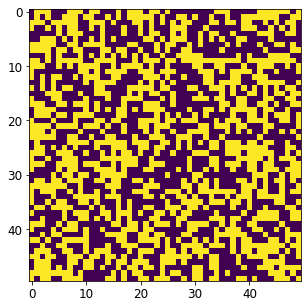

In [2]:
# we apply the same procedure as the cell above, but we use the metropolis algorithm with the mean_field approximation

# note: for mf approx the critical temperature is 4 (T_c = J*4/kb)
temperatures = [3, 4, 5]

for T in temperatures:
    # create initial random configuration
    ising = Ising(50, 50, T, 0, 1)

    # set up figure, plot first frame
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    # draw the initial configuration,
    # naming the plot "im".
    im = ax.imshow(ising.matrix)
    
    
    for t in range(10000):
        # update the system
        ising.metropolis_mf(100)
        # replot every 1000 MC updates
        
        if t%100==0:
            # update the data of the plot (not the whole figure!)
            im.set_data(ising.matrix)
            # rerender
            display.display(plt.gcf())
            display.clear_output(wait=True)
        
    
    # save the final configuration
    fig.savefig(f'./fig/final_state_mf_{T}.pdf', dpi=720)

## Energy Plot for Wolff algorithm
We now plot the energy as a function of the number of step to see after how many sweeps the system reach the equilibrium

In [10]:
# set system size, temperature
n1 = 100
n2 = 100
T1 = 1.5
T2 = 3.5
T_c = 2/np.log(1+np.sqrt(2))

# run some Wolff sweeps, check if equilibrium
ising_T1 = Ising(n1, n2, T=T1, B=0, J=1)
ising_T2 = Ising(n1, n2, T=T2, B=0, J=1)
ising_T_c = Ising(n1, n2, T=T_c, B=0, J=1)

for i in range(50):
    ising_T1.update_ham()
    ising_T2.update_ham()
    ising_T_c.update_ham()
    ising_T1.SweepWolff()
    ising_T2.SweepWolff()
    ising_T_c.SweepWolff()

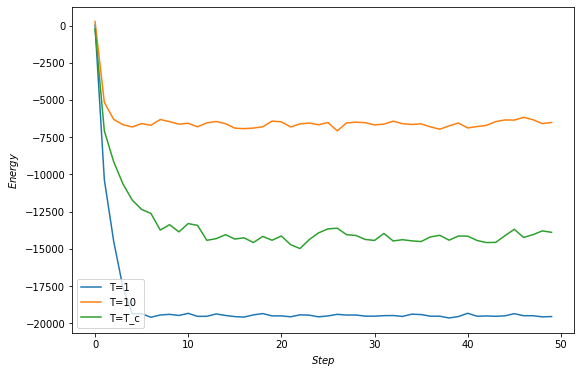

In [11]:
E_T1 = ising_T1.ham
E_T2 = ising_T2.ham
E_T_c = ising_T_c.ham

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(E_T1, label="T=1")
ax.plot(E_T2, label="T=10")
ax.plot(E_T_c, label="T=T_c")

ax.set_xlabel("$Step$")
ax.set_ylabel("$Energy$")
ax.legend(loc=3)

We can see that after around 10 step the system reach the equilibrium

In [2]:
# We create a function to compute couple of value for (magnetization, temperature)
# in order to check phase transition and the correctness of the value of T_c
# computed with the metropolis algorithm

def compute_temp_mag(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    magnetizations = np.zeros(n_temperatures)
    for i,t in enumerate (temperatures):
        ising = Ising(n1, n2, t, B, J)
        ising.metropolis(n_repetitions)
        ising.update_mag()
        magnetizations[i] = ising.mag[-1]/n1/n2
        print ( '[',t,',',magnetizations[i],']')
    return(temperatures, magnetizations)

In [3]:
# We create a function to compute couple of value for (magnetization, temperature)
# in order to check phase transition and the correctness of the value of T_c
# computed with the wolff algorithm

def compute_mag_wolff(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    magnetizations = np.zeros(n_temperatures)
    for i, t in enumerate (temperatures):
        ising = Ising(n1, n2, t, B, J)
        ising.SweepWolff(n_repetitions)
        ising.update_mag()
        magnetizations[i] = abs(ising.mag[-1])
        #print ( '[',t,',',magnetizations[i],']')
    return(temperatures, magnetizations)

In [10]:
# we run the function defined above that use the wolff algorithm
#%%time

temp, mag = compute_mag_wolff(100,100,0,1,1.5,3.5,80,10)

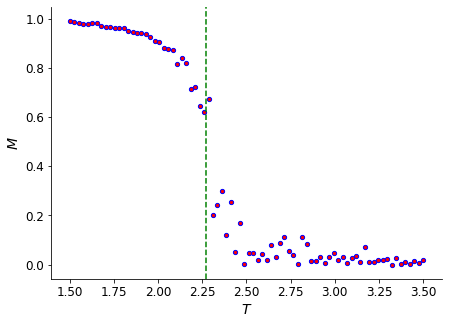

In [11]:
# we visualize the results in the M T plane
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.scatter(temp, mag, edgecolors="b", color="r", s=18)
ax.axvline(T_c, c="green", lw=1.5, ls = "dashed")
#ax.set_title("Magnetization over temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$")
fig.savefig('./fig/M-T.pdf', dpi=720)

We now write a function to plot the evolution of the magnetization in order to find fixed points of the system

In [13]:
# We define the curve predicted by the Onsager solution 
def onsager_solution(t):
    return  (1-(np.sinh(2/t))**(-4) )**(1/8)
x = np.linspace(0,T_c-0.0001,10000000)
x2 = np.linspace(T_c,4,3)
x_fin = np.append(x,x2)
y_fin = np.append(onsager_solution(x),[0,0,0])

/home/giulio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/giulio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in sinh
  This is separate from the ipykernel package so we can avoid doing imports until
/home/giulio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sinh
  This is separate from the ipykernel package so we can avoid doing imports until


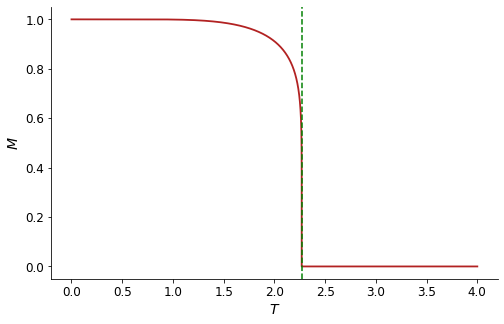

In [14]:
# we visualize the theoretical curve
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(8,5))
plt.plot(x_fin, y_fin, lw=1.8, c="firebrick")
ax.axvline(T_c, c="g", lw=1.5, ls = "dashed")
#ax.set_title("Theoretical Magnetization over Temperature", pad=20)
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");

fig.savefig('./fig/mag_onsager.pdf', dpi=720)

### Basin of attraction
We visualize in the M-T plane the step by step evolution of the magnetization.

In [4]:
def mag_evol(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    #magnetizations = [[]] * n_temperatures
    magnetizations = np.zeros((n_temperatures, n_repetitions))
    for i, t in enumerate(temperatures):
        ising = Ising(n1, n2, t, B, J)
        print(i, end="\r")
        for j in range(n_repetitions):
            ising.update_mag()
            ising.SweepWolff()
            magnetizations[i][j] = (ising.mag[-1])
    return(temperatures, magnetizations)

In [35]:
%%time

temp, mag = mag_evol(250,250,0,1,1.5,3.5,70,15)



CPU times: user 9min 54s, sys: 112 ms, total: 9min 55s
Wall time: 9min 55s


In [38]:
x = np.linspace(1.5,T_c-0.0001,10000000)
x2 = np.linspace(T_c,3.5,3)
x_fin = np.append(x,x2)
y_fin = np.append(onsager_solution(x),[0,0,0])

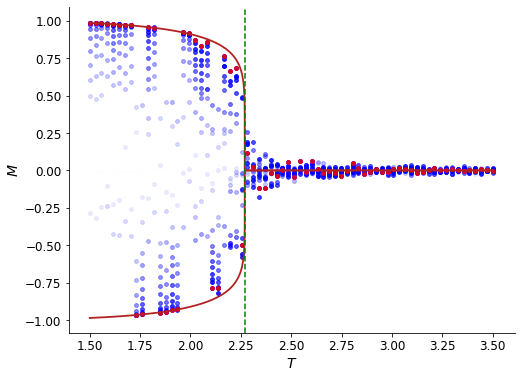

In [39]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i, t in enumerate(temp):
    temper = [t]*len(mag[i])
    for j in range(len(mag[i])):
        ax.scatter(t, mag[i][j], color="b", s=15, alpha=(j+0.05)/(len(mag[i])+0.05))
    ax.scatter(t, mag[i][-1], color="r", s=15, alpha=0.8)
ax.plot(x_fin, y_fin, lw=1.8, c="firebrick")
ax.plot(x_fin, -y_fin, lw=1.8, c="firebrick")
ax.axvline(T_c, c="green", lw=1.5, ls = "dashed")
#ax.set_title("Magnetization over Temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");

fig.savefig('./fig/mag_evol.pdf', dpi=720)

In [38]:
def mag_evol_mf(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    #magnetizations = [[]] * n_temperatures
    magnetizations = np.zeros((n_temperatures, n_repetitions))
    for i, t in enumerate(temperatures):
        ising = Ising(n1, n2, t, B, J)
        print(i, end="\r")
        for j in range(n_repetitions):
            ising.update_mag()
            ising.metropolis_mf(160000) #160.000 PER LATTICE 400x400
            magnetizations[i][j] = (ising.mag[-1])
    return(temperatures, magnetizations)

In [31]:
%%time

temp_mf, mag_mf = mag_evol_mf(250,250,0,1,3,5,70,15)

CPU times: user 2h 39min 44s, sys: 24.9 s, total: 2h 40min 9s
Wall time: 3h 6min 10s


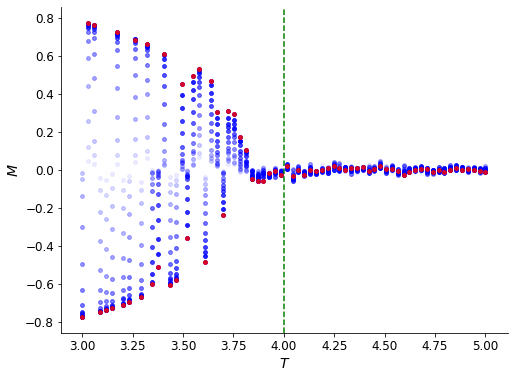

In [35]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i, t in enumerate(temp_mf):
    temper = [t]*len(mag_mf[i])
    for j in range(len(mag_mf[i])):
        ax.scatter(t, mag_mf[i][j], color="b", s=15, alpha=(j+0.05)/(len(mag_mf[i])+0.05))
    ax.scatter(t, mag_mf[i][-1], color="r", s=15, alpha=0.8)
#ax.plot(x_fin, y_fin, lw=1.8, c="firebrick")
#ax.plot(x_fin, -y_fin, lw=1.8, c="firebrick")
ax.axvline(4, c="green", lw=1.5, ls = "dashed")
#ax.set_title("Magnetization over Temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");

fig.savefig('./fig/mag_evol_mf.pdf', dpi=720)

In [39]:
%%time

temp_mf_test, mag_mf_test = mag_evol_mf(400,400,0,1,3,5,2,15)

CPU times: user 14min 48s, sys: 8.54 s, total: 14min 56s
Wall time: 16min 36s


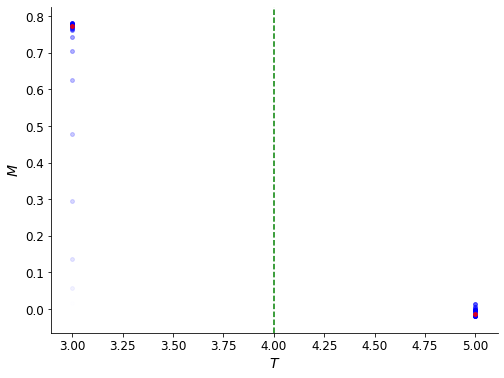

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i, t in enumerate(temp_mf_test):
    temper = [t]*len(mag_mf_test[i])
    for j in range(len(mag_mf_test[i])):
        ax.scatter(t, mag_mf_test[i][j], color="b", s=15, alpha=(j+0.05)/(len(mag_mf_test[i])+0.05))
    ax.scatter(t, mag_mf_test[i][-1], color="r", s=15, alpha=0.8)
#ax.plot(x_fin, y_fin, lw=1.8, c="firebrick")
#ax.plot(x_fin, -y_fin, lw=1.8, c="firebrick")
ax.axvline(4, c="green", lw=1.5, ls = "dashed")
#ax.set_title("Magnetization over Temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");